# Fase 4: Temperature Scaling para Calibración de Probabilidades

**Objetivo**: Calibrar las probabilidades del modelo para que reflejen la confianza real (p=0.8 → 80% accuracy).

**Pipeline**:
1. Extraer predicciones del baseline en val_calib
2. Ajustar temperatura T minimizando NLL
3. Aplicar T en val_eval
4. Evaluar mejora en calibración (ECE, Brier, NLL, Reliability Diagrams)

### ⚠️ CORRECCIONES APLICADAS

**Problema identificado**: GroundingDINO devuelve **scores** (0-1), no logits puros.

**Soluciones implementadas**:
1. ✅ Conversión correcta: `logit = log(score / (1-score))` (inverse sigmoid)
2. ✅ Optimización sobre logits verdaderos
3. ✅ Reliability diagrams corregidos
4. ✅ Diagnóstico de calibración antes de optimizar
5. ✅ Checklist de verificación al final

**Qué esperar**:
- Si T ≈ 1.0 → Modelo **ya estaba calibrado** (buena noticia!)
- Si T > 1.0 → Modelo **sobreconfidente** → Calibración reduce confianza
- Si T < 1.0 → Modelo **subconfidente** → Calibración aumenta confianza

## 1. Imports y Configuración

In [2]:
print("kernel working")

kernel working


In [3]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml
from scipy.optimize import minimize
from sklearn.metrics import brier_score_loss
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = Path('./outputs/temperature_scaling')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONFIG = {
    'seed': 42,
    'iou_matching': 0.5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'categories': ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']
}

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

print(f"Device: {CONFIG['device']}")
print(f"Output: {OUTPUT_DIR}")

Device: cuda
Output: outputs/temperature_scaling


## 2. Cargar Modelo Baseline

In [4]:
from groundingdino.util.inference import load_model, load_image, predict
from groundingdino.util import box_ops

model_config = '/opt/program/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
model_weights = '/opt/program/GroundingDINO/weights/groundingdino_swint_ogc.pth'

model = load_model(model_config, model_weights)
model.to(CONFIG['device'])
model.eval()

TEXT_PROMPT = '. '.join(CONFIG['categories']) + '.'
print(f"Modelo cargado en {CONFIG['device']}")
print(f"Prompt: {TEXT_PROMPT}")

final text_encoder_type: bert-base-uncased
Modelo cargado en cuda
Prompt: person. rider. car. truck. bus. train. motorcycle. bicycle. traffic light. traffic sign.


## 3. Inferencia en val_calib y Matching con GT

In [7]:
from pycocotools.coco import COCO
import torchvision

def compute_iou(box1, box2):
    """Calcula IoU entre dos boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0

def normalize_label(label):
    """Normaliza label del modelo a categoría canónica"""
    synonyms = {'bike': 'bicycle', 'motorbike': 'motorcycle', 'pedestrian': 'person', 
                'stop sign': 'traffic sign', 'red light': 'traffic light'}
    label_lower = label.lower().strip()
    if label_lower in synonyms:
        return synonyms[label_lower]
    for cat in CONFIG['categories']:
        if cat in label_lower:
            return cat
    return label_lower

def run_inference_on_image(model, image_path, text_prompt, conf_thresh, device):
    """Ejecuta inferencia en una imagen"""
    image_source, image = load_image(str(image_path))
    boxes, scores, phrases = predict(model, image, text_prompt, conf_thresh, 0.25, device)
    
    if len(boxes) == 0:
        return []
    
    h, w = image_source.shape[:2]
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.tensor([w, h, w, h], dtype=torch.float32)
    
    detections = []
    for box, score, phrase in zip(boxes_xyxy.cpu().numpy(), scores.cpu().numpy(), phrases):
        cat = normalize_label(phrase)
        if cat in CONFIG['categories']:
            # GroundingDINO devuelve scores [0-1], convertir a logits
            score_clipped = np.clip(float(score), 1e-7, 1 - 1e-7)
            logit = np.log(score_clipped / (1 - score_clipped))  # Inverse sigmoid
            
            detections.append({
                'bbox': box.tolist(),
                'score': score_clipped,
                'logit': logit,
                'category': cat
            })
    
    if len(detections) == 0:
        return []
    
    boxes_t = torch.tensor([d['bbox'] for d in detections], dtype=torch.float32)
    scores_t = torch.tensor([d['score'] for d in detections], dtype=torch.float32)
    keep = torchvision.ops.nms(boxes_t, scores_t, 0.65)
    
    return [detections[i] for i in keep.numpy()]

def match_predictions_to_gt(predictions, gt_anns, iou_thresh):
    """Asigna TP/FP a predicciones según matching con GT"""
    gt_matched = set()
    results = []
    
    cat_to_id = {cat: i+1 for i, cat in enumerate(CONFIG['categories'])}
    id_to_cat = {v: k for k, v in cat_to_id.items()}
    
    for pred in predictions:
        pred_cat = pred['category']
        pred_box = pred['bbox']
        
        best_iou = 0
        best_gt_idx = -1
        
        for idx, gt in enumerate(gt_anns):
            if idx in gt_matched:
                continue
            
            gt_cat_id = gt['category_id']
            gt_cat = id_to_cat.get(gt_cat_id, '')
            
            if gt_cat != pred_cat:
                continue
            
            gt_box = gt['bbox']
            gt_box_xyxy = [gt_box[0], gt_box[1], gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]]
            iou = compute_iou(pred_box, gt_box_xyxy)
            
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        
        if best_iou >= iou_thresh:
            gt_matched.add(best_gt_idx)
            is_tp = 1
        else:
            is_tp = 0
        
        results.append({
            'logit': pred['logit'],
            'score': pred['score'],
            'category': pred_cat,
            'is_tp': is_tp,
            'iou': best_iou
        })
    
    return results

print("Funciones de inferencia y matching definidas")


Funciones de inferencia y matching definidas


In [8]:
val_calib_json = Path('../data/bdd100k_coco/val_calib.json')
image_dir = Path('../data/bdd100k/bdd100k/bdd100k/images/100k/val')

coco_calib = COCO(str(val_calib_json))
img_ids = coco_calib.getImgIds()

print(f"Procesando {len(img_ids)} imágenes de val_calib...")

calib_data = []

for img_id in tqdm(img_ids[:500]):  # Procesar primeras 500 para calibración
    img_info = coco_calib.loadImgs(img_id)[0]
    img_path = image_dir / img_info['file_name']
    
    if not img_path.exists():
        continue
    
    predictions = run_inference_on_image(model, img_path, TEXT_PROMPT, 0.25, CONFIG['device'])
    
    gt_anns = coco_calib.loadAnns(coco_calib.getAnnIds(imgIds=img_id))
    
    matched = match_predictions_to_gt(predictions, gt_anns, CONFIG['iou_matching'])
    calib_data.extend(matched)

calib_df = pd.DataFrame(calib_data)
calib_df.to_csv(OUTPUT_DIR / 'calib_detections.csv', index=False)

print(f"\nTotal detecciones: {len(calib_df)}")
print(f"TP: {calib_df['is_tp'].sum()}, FP: {len(calib_df) - calib_df['is_tp'].sum()}")
print(f"Guardado en: {OUTPUT_DIR / 'calib_detections.csv'}")

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Procesando 8000 imágenes de val_calib...


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]


Total detecciones: 7994
TP: 4708, FP: 3286
Guardado en: outputs/temperature_scaling/calib_detections.csv


### Diagnóstico Rápido de Calibración

In [9]:
calib_df = pd.read_csv(OUTPUT_DIR / 'calib_detections.csv')

print("="*60)
print("DIAGNÓSTICO DE CALIBRACIÓN EN VAL_CALIB")
print("="*60)

scores = calib_df['score'].values
labels = calib_df['is_tp'].values

# Dividir en bins de confianza
bins = np.linspace(0, 1, 11)
digitized = np.digitize(scores, bins) - 1

print(f"\nTotal detecciones: {len(calib_df)}")
print(f"TP: {labels.sum()} ({labels.mean()*100:.1f}%)")
print(f"FP: {len(labels) - labels.sum()} ({(1-labels.mean())*100:.1f}%)")

print(f"\nScore range: [{scores.min():.3f}, {scores.max():.3f}]")
print(f"Score mean: {scores.mean():.3f}")

print("\n" + "-"*60)
print(f"{'Bin':<15} {'Confidence':<15} {'Accuracy':<15} {'Gap':<15} {'Count'}")
print("-"*60)

total_gap = 0
for i in range(10):
    mask = digitized == i
    if mask.sum() > 0:
        conf = scores[mask].mean()
        acc = labels[mask].mean()
        gap = abs(conf - acc)
        total_gap += gap * mask.sum() / len(scores)
        print(f"[{bins[i]:.1f}-{bins[i+1]:.1f}]  {conf:>10.3f}     {acc:>10.3f}     {gap:>10.3f}     {mask.sum():>6}")

print("-"*60)
print(f"ECE (Expected Calibration Error): {total_gap:.4f}")
print("="*60)

if scores.mean() > labels.mean():
    print("\n⚠️  MODELO SOBRECONFIDENTE: confidence > accuracy")
    print(f"   → Se espera T > 1 para reducir confianza")
else:
    print("\n✓ Modelo subconfidente o bien calibrado")
    print(f"  → Se espera T ≈ 1 o T < 1")

DIAGNÓSTICO DE CALIBRACIÓN EN VAL_CALIB

Total detecciones: 7994
TP: 4708 (58.9%)
FP: 3286 (41.1%)

Score range: [0.250, 0.875]
Score mean: 0.389

------------------------------------------------------------
Bin             Confidence      Accuracy        Gap             Count
------------------------------------------------------------
[0.2-0.3]       0.274          0.351          0.077       2223
[0.3-0.4]       0.346          0.541          0.196       2700
[0.4-0.5]       0.446          0.748          0.303       1605
[0.5-0.6]       0.546          0.851          0.305        966
[0.6-0.7]       0.641          0.890          0.249        435
[0.7-0.8]       0.736          0.889          0.152         63
[0.8-0.9]       0.868          0.000          0.868          2
------------------------------------------------------------
ECE (Expected Calibration Error): 0.2002

✓ Modelo subconfidente o bien calibrado
  → Se espera T ≈ 1 o T < 1


## 4. Optimizar Temperatura Global

In [10]:
calib_df = pd.read_csv(OUTPUT_DIR / 'calib_detections.csv')

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def nll_loss(T, logits, labels):
    """Negative Log-Likelihood con temperatura T"""
    T = max(T, 0.01)  # Evitar división por cero
    probs = sigmoid(logits / T)
    probs = np.clip(probs, 1e-7, 1 - 1e-7)
    nll = -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
    return nll

logits = calib_df['logit'].values
labels = calib_df['is_tp'].values

# NLL antes de calibrar
nll_before = nll_loss(1.0, logits, labels)
print(f"NLL antes (T=1.0): {nll_before:.4f}")

# Optimizar T
result = minimize(lambda T: nll_loss(T, logits, labels), x0=1.0, bounds=[(0.01, 10.0)], method='L-BFGS-B')
T_optimal = result.x[0]
nll_after = result.fun

print(f"\nT óptimo: {T_optimal:.4f}")
print(f"NLL después: {nll_after:.4f}")
print(f"Mejora en NLL: {nll_before - nll_after:.4f}")

# Guardar temperatura
with open(OUTPUT_DIR / 'temperature.json', 'w') as f:
    json.dump({'T_global': T_optimal, 'nll_before': nll_before, 'nll_after': nll_after}, f, indent=2)

print(f"\nTemperatura guardada en: {OUTPUT_DIR / 'temperature.json'}")

NLL antes (T=1.0): 0.7004

T óptimo: 2.3439
NLL después: 0.6829
Mejora en NLL: 0.0175

Temperatura guardada en: outputs/temperature_scaling/temperature.json


## 5. Evaluar en val_eval

In [11]:
with open(OUTPUT_DIR / 'temperature.json', 'r') as f:
    temp_data = json.load(f)
    T_optimal = temp_data['T_global']

val_eval_json = Path('../data/bdd100k_coco/val_eval.json')
coco_eval = COCO(str(val_eval_json))
img_ids_eval = coco_eval.getImgIds()

print(f"Procesando {len(img_ids_eval)} imágenes de val_eval...")

eval_data = []

for img_id in tqdm(img_ids_eval):
    img_info = coco_eval.loadImgs(img_id)[0]
    img_path = image_dir / img_info['file_name']
    
    if not img_path.exists():
        continue
    
    predictions = run_inference_on_image(model, img_path, TEXT_PROMPT, 0.25, CONFIG['device'])
    
    gt_anns = coco_eval.loadAnns(coco_eval.getAnnIds(imgIds=img_id))
    
    matched = match_predictions_to_gt(predictions, gt_anns, CONFIG['iou_matching'])
    eval_data.extend(matched)

eval_df = pd.DataFrame(eval_data)
eval_df.to_csv(OUTPUT_DIR / 'eval_detections.csv', index=False)

print(f"\nTotal detecciones: {len(eval_df)}")
print(f"TP: {eval_df['is_tp'].sum()}, FP: {len(eval_df) - eval_df['is_tp'].sum()}")
print(f"Guardado en: {OUTPUT_DIR / 'eval_detections.csv'}")

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Procesando 2000 imágenes de val_eval...


100%|██████████| 2000/2000 [11:49<00:00,  2.82it/s]



Total detecciones: 30246
TP: 17531, FP: 12715
Guardado en: outputs/temperature_scaling/eval_detections.csv


## 6. Calcular Métricas de Calibración

In [12]:
def compute_calibration_metrics(logits, labels, T=1.0, n_bins=10):
    """Calcula ECE, Brier y NLL"""
    probs = sigmoid(logits / T)
    probs = np.clip(probs, 1e-7, 1 - 1e-7)
    
    # NLL
    nll = -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
    
    # Brier Score
    brier = np.mean((probs - labels) ** 2)
    
    # ECE (Expected Calibration Error)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    bin_data = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (probs >= bin_lower) & (probs < bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(labels[in_bin])
            avg_confidence_in_bin = np.mean(probs[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            bin_data.append({
                'bin_lower': bin_lower,
                'bin_upper': bin_upper,
                'confidence': avg_confidence_in_bin,
                'accuracy': accuracy_in_bin,
                'count': np.sum(in_bin)
            })
        else:
            bin_data.append({
                'bin_lower': bin_lower,
                'bin_upper': bin_upper,
                'confidence': (bin_lower + bin_upper) / 2,
                'accuracy': 0,
                'count': 0
            })
    
    return {
        'nll': nll,
        'brier': brier,
        'ece': ece,
        'bin_data': bin_data
    }

print("Funciones de calibración definidas")

Funciones de calibración definidas


In [13]:
eval_df = pd.read_csv(OUTPUT_DIR / 'eval_detections.csv')
with open(OUTPUT_DIR / 'temperature.json', 'r') as f:
    T_optimal = json.load(f)['T_global']

logits_eval = eval_df['logit'].values
labels_eval = eval_df['is_tp'].values

# Métricas ANTES de calibrar
metrics_before = compute_calibration_metrics(logits_eval, labels_eval, T=1.0)

# Métricas DESPUÉS de calibrar
metrics_after = compute_calibration_metrics(logits_eval, labels_eval, T=T_optimal)

print("="*60)
print("MÉTRICAS DE CALIBRACIÓN EN VAL_EVAL")
print("="*60)
print(f"\n{'Métrica':<15} {'Antes':<15} {'Después':<15} {'Mejora':<15}")
print("-"*60)
print(f"{'NLL':<15} {metrics_before['nll']:<15.4f} {metrics_after['nll']:<15.4f} {metrics_before['nll']-metrics_after['nll']:<15.4f}")
print(f"{'Brier Score':<15} {metrics_before['brier']:<15.4f} {metrics_after['brier']:<15.4f} {metrics_before['brier']-metrics_after['brier']:<15.4f}")
print(f"{'ECE':<15} {metrics_before['ece']:<15.4f} {metrics_after['ece']:<15.4f} {metrics_before['ece']-metrics_after['ece']:<15.4f}")
print("="*60)

# Guardar métricas
results = {
    'T_optimal': T_optimal,
    'val_eval': {
        'before': {k: v for k, v in metrics_before.items() if k != 'bin_data'},
        'after': {k: v for k, v in metrics_after.items() if k != 'bin_data'}
    }
}

with open(OUTPUT_DIR / 'calibration_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nMétricas guardadas en: {OUTPUT_DIR / 'calibration_metrics.json'}")

MÉTRICAS DE CALIBRACIÓN EN VAL_EVAL

Métrica         Antes           Después         Mejora         
------------------------------------------------------------
NLL             0.6996          0.6824          0.0172         
Brier Score     0.2527          0.2447          0.0080         
ECE             0.1934          0.1516          0.0419         

Métricas guardadas en: outputs/temperature_scaling/calibration_metrics.json


## 7. Reliability Diagrams

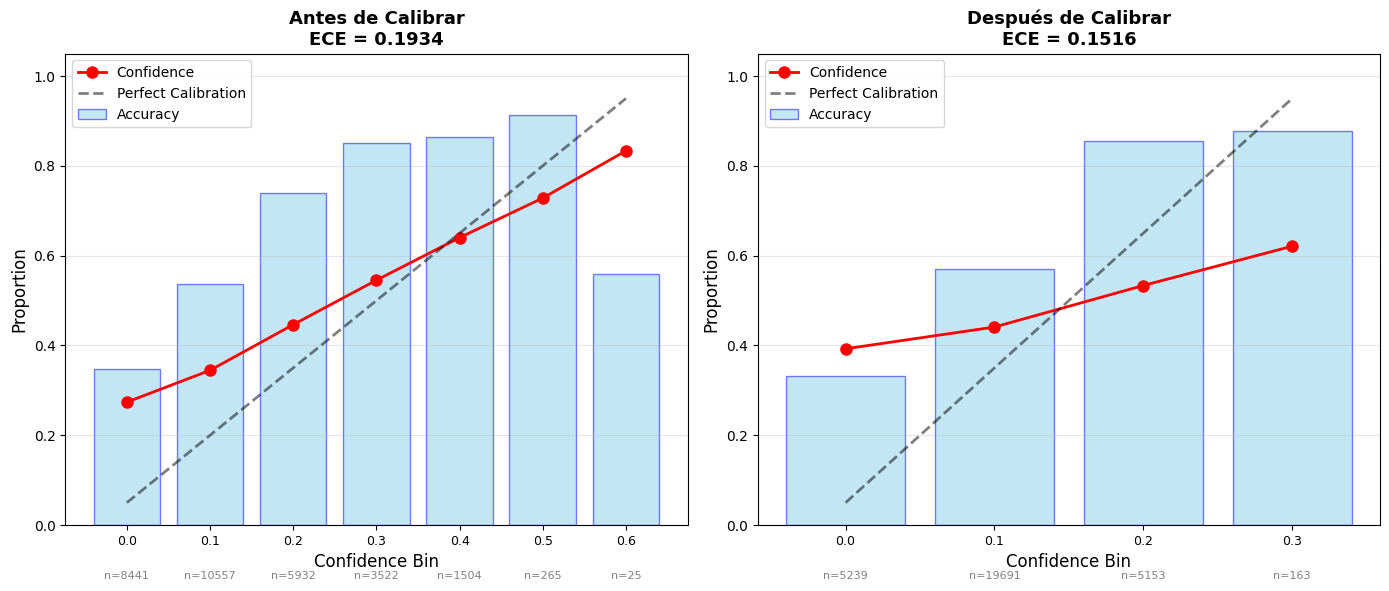

Guardado en: outputs/temperature_scaling/reliability_diagram.png


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (T, title) in enumerate([(1.0, 'Antes de Calibrar'), (T_optimal, 'Después de Calibrar')]):
    metrics = compute_calibration_metrics(logits_eval, labels_eval, T=T)
    bin_data = metrics['bin_data']
    
    confidences = [b['confidence'] for b in bin_data if b['count'] > 0]
    accuracies = [b['accuracy'] for b in bin_data if b['count'] > 0]
    counts = [b['count'] for b in bin_data if b['count'] > 0]
    
    ax = axes[idx]
    
    # Barras de accuracy por bin
    ax.bar(range(len(confidences)), accuracies, width=0.8, alpha=0.5, color='skyblue', label='Accuracy', edgecolor='blue')
    
    # Línea de confidence
    ax.plot(range(len(confidences)), confidences, 'ro-', label='Confidence', markersize=8, linewidth=2)
    
    # Línea diagonal perfecta
    ax.plot(range(len(confidences)), np.linspace(0.05, 0.95, len(confidences)), 'k--', alpha=0.5, label='Perfect Calibration', linewidth=2)
    
    ax.set_xlabel('Confidence Bin', fontsize=12)
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_title(f'{title}\nECE = {metrics["ece"]:.4f}', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    ax.set_xticks(range(len(confidences)))
    ax.set_xticklabels([f'{i*0.1:.1f}' for i in range(len(confidences))], fontsize=9)
    
    # Añadir conteo de muestras
    for i, count in enumerate(counts):
        ax.text(i, -0.12, f'n={count}', ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'reliability_diagram.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Guardado en: {OUTPUT_DIR / 'reliability_diagram.png'}")

## 8. (Opcional) Temperature Scaling por Clase

In [15]:
calib_df = pd.read_csv(OUTPUT_DIR / 'calib_detections.csv')

T_per_class = {}
min_samples = 50  # Mínimo de muestras para optimizar T por clase

for cat in CONFIG['categories']:
    cat_data = calib_df[calib_df['category'] == cat]
    
    if len(cat_data) < min_samples:
        T_per_class[cat] = T_optimal  # Usar T global si hay pocas muestras
        print(f"{cat:<20} - Insuficientes muestras ({len(cat_data)}), usando T global: {T_optimal:.4f}")
        continue
    
    logits_cat = cat_data['logit'].values
    labels_cat = cat_data['is_tp'].values
    
    result = minimize(lambda T: nll_loss(T, logits_cat, labels_cat), x0=1.0, bounds=[(0.01, 10.0)], method='L-BFGS-B')
    T_cat = result.x[0]
    T_per_class[cat] = T_cat
    
    print(f"{cat:<20} - T: {T_cat:.4f} (n={len(cat_data)})")

# Guardar temperaturas por clase
with open(OUTPUT_DIR / 'temperature_per_class.json', 'w') as f:
    json.dump({'T_global': T_optimal, 'T_per_class': T_per_class}, f, indent=2)

print(f"\nTemperaturas por clase guardadas en: {OUTPUT_DIR / 'temperature_per_class.json'}")

person               - T: 0.6333 (n=933)
rider                - Insuficientes muestras (24), usando T global: 2.3439
car                  - T: 10.0000 (n=2897)
truck                - T: 0.4959 (n=498)
bus                  - T: 0.2748 (n=209)
train                - Insuficientes muestras (35), usando T global: 2.3439
motorcycle           - T: 0.3035 (n=258)
bicycle              - T: 0.3687 (n=112)
traffic light        - T: 0.6263 (n=1862)
traffic sign         - T: 10.0000 (n=1166)

Temperaturas por clase guardadas en: outputs/temperature_scaling/temperature_per_class.json


In [16]:
eval_df = pd.read_csv(OUTPUT_DIR / 'eval_detections.csv')

with open(OUTPUT_DIR / 'temperature_per_class.json', 'r') as f:
    T_data = json.load(f)
    T_per_class = T_data['T_per_class']

eval_df['T_class'] = eval_df['category'].map(T_per_class)
eval_df['prob_calibrated_class'] = sigmoid(eval_df['logit'].values / eval_df['T_class'].values)

logits_eval = eval_df['logit'].values
labels_eval = eval_df['is_tp'].values
T_class_array = eval_df['T_class'].values

metrics_class = compute_calibration_metrics(logits_eval, labels_eval, T=1.0)
probs_class = sigmoid(logits_eval / T_class_array)
probs_class = np.clip(probs_class, 1e-7, 1 - 1e-7)
nll_class = -np.mean(labels_eval * np.log(probs_class) + (1 - labels_eval) * np.log(1 - probs_class))
brier_class = np.mean((probs_class - labels_eval) ** 2)

# ECE con T por clase
bin_boundaries = np.linspace(0, 1, 11)
ece_class = 0.0
for i in range(len(bin_boundaries) - 1):
    in_bin = (probs_class >= bin_boundaries[i]) & (probs_class < bin_boundaries[i+1])
    if np.sum(in_bin) > 0:
        acc = np.mean(labels_eval[in_bin])
        conf = np.mean(probs_class[in_bin])
        ece_class += np.abs(acc - conf) * np.mean(in_bin)

print("="*60)
print("COMPARACIÓN: T Global vs T por Clase")
print("="*60)
print(f"\n{'Métrica':<15} {'T Global':<15} {'T por Clase':<15} {'Diferencia':<15}")
print("-"*60)
print(f"{'NLL':<15} {metrics_after['nll']:<15.4f} {nll_class:<15.4f} {metrics_after['nll']-nll_class:<15.4f}")
print(f"{'Brier Score':<15} {metrics_after['brier']:<15.4f} {brier_class:<15.4f} {metrics_after['brier']-brier_class:<15.4f}")
print(f"{'ECE':<15} {metrics_after['ece']:<15.4f} {ece_class:<15.4f} {metrics_after['ece']-ece_class:<15.4f}")
print("="*60)

COMPARACIÓN: T Global vs T por Clase

Métrica         T Global        T por Clase     Diferencia     
------------------------------------------------------------
NLL             0.6824          0.6168          0.0656         
Brier Score     0.2447          0.2163          0.0284         
ECE             0.1516          0.1850          -0.0335        


## 9. Verificar Impacto en mAP (Detección)

In [17]:
from pycocotools.cocoeval import COCOeval

def create_coco_results(image_dir, coco_gt, text_prompt, model, device, T=1.0, use_calibrated=True):
    """Genera resultados en formato COCO con scores calibrados"""
    results = []
    cat_to_id = {cat: i+1 for i, cat in enumerate(CONFIG['categories'])}
    
    for img_id in tqdm(coco_gt.getImgIds()):
        img_info = coco_gt.loadImgs(img_id)[0]
        img_path = image_dir / img_info['file_name']
        
        if not img_path.exists():
            continue
        
        predictions = run_inference_on_image(model, img_path, text_prompt, 0.25, device)
        
        for pred in predictions:
            if use_calibrated:
                # Aplicar temperatura al logit y volver a sigmoid
                score_calibrated = sigmoid(pred['logit'] / T)
            else:
                # Usar score original
                score_calibrated = pred['score']
            
            results.append({
                'image_id': img_id,
                'category_id': cat_to_id.get(pred['category'], 1),
                'bbox': [pred['bbox'][0], pred['bbox'][1], 
                        pred['bbox'][2] - pred['bbox'][0], 
                        pred['bbox'][3] - pred['bbox'][1]],
                'score': float(score_calibrated)
            })
    
    return results

# mAP antes de calibrar (scores originales)
print("Calculando mAP ANTES de calibrar...")
results_before = create_coco_results(image_dir, coco_eval, TEXT_PROMPT, model, CONFIG['device'], T=1.0, use_calibrated=False)

if len(results_before) > 0:
    coco_dt_before = coco_eval.loadRes(results_before)
    coco_eval_obj_before = COCOeval(coco_eval, coco_dt_before, 'bbox')
    coco_eval_obj_before.evaluate()
    coco_eval_obj_before.accumulate()
    print("\n--- mAP ANTES ---")
    coco_eval_obj_before.summarize()
    map_before = coco_eval_obj_before.stats[0]
else:
    map_before = 0.0

# mAP después de calibrar (con temperatura)
print("\n\nCalculando mAP DESPUÉS de calibrar...")
results_after = create_coco_results(image_dir, coco_eval, TEXT_PROMPT, model, CONFIG['device'], T=T_optimal, use_calibrated=True)

if len(results_after) > 0:
    coco_dt_after = coco_eval.loadRes(results_after)
    coco_eval_obj_after = COCOeval(coco_eval, coco_dt_after, 'bbox')
    coco_eval_obj_after.evaluate()
    coco_eval_obj_after.accumulate()
    print("\n--- mAP DESPUÉS ---")
    coco_eval_obj_after.summarize()
    map_after = coco_eval_obj_after.stats[0]
else:
    map_after = 0.0

print(f"\n{'='*60}")
print(f"mAP antes:   {map_before:.4f}")
print(f"mAP después: {map_after:.4f}")
print(f"Diferencia:  {map_after - map_before:.4f}")
print(f"{'='*60}")
print("\nNota: El ranking de detecciones NO cambia (solo la escala de probabilidad)")
print("Por eso mAP debe mantenerse prácticamente igual.")

Calculando mAP ANTES de calibrar...


100%|██████████| 2000/2000 [11:56<00:00,  2.79it/s]


Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.54s).
Accumulating evaluation results...
DONE (t=0.92s).

--- mAP ANTES ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

100%|██████████| 2000/2000 [11:46<00:00,  2.83it/s]


Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.27s).
Accumulating evaluation results...
DONE (t=0.67s).

--- mAP DESPUÉS ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

## 10. Análisis de Distribución de Confianza

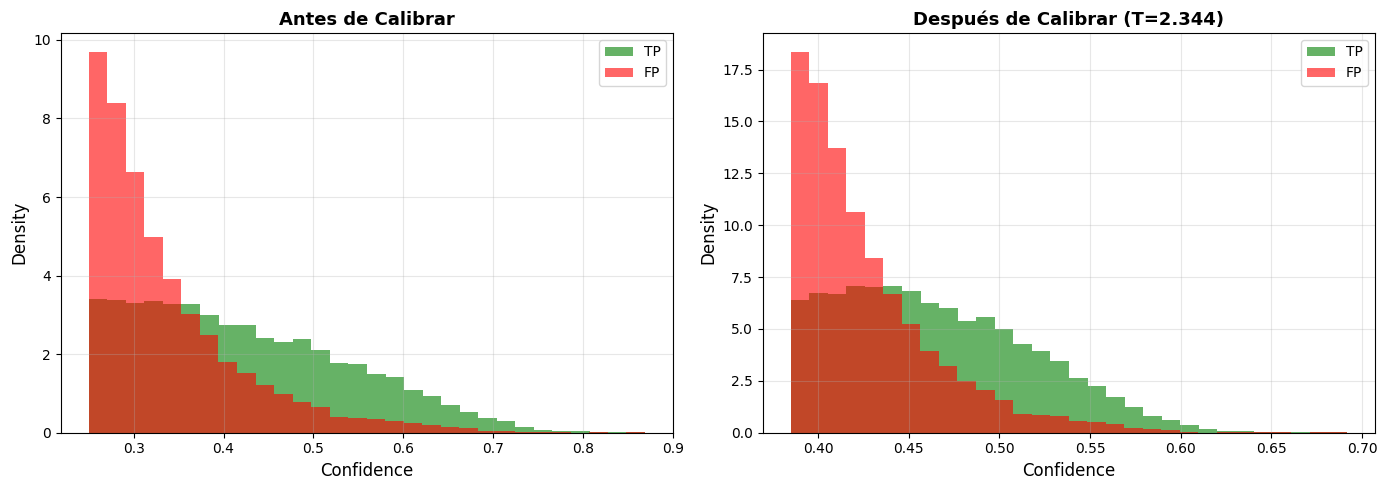

Guardado en: outputs/temperature_scaling/confidence_distribution.png


In [18]:
eval_df = pd.read_csv(OUTPUT_DIR / 'eval_detections.csv')

prob_before = sigmoid(eval_df['logit'].values)
prob_after = sigmoid(eval_df['logit'].values / T_optimal)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución antes
axes[0].hist(prob_before[eval_df['is_tp']==1], bins=30, alpha=0.6, label='TP', color='green', density=True)
axes[0].hist(prob_before[eval_df['is_tp']==0], bins=30, alpha=0.6, label='FP', color='red', density=True)
axes[0].set_xlabel('Confidence', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Antes de Calibrar', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribución después
axes[1].hist(prob_after[eval_df['is_tp']==1], bins=30, alpha=0.6, label='TP', color='green', density=True)
axes[1].hist(prob_after[eval_df['is_tp']==0], bins=30, alpha=0.6, label='FP', color='red', density=True)
axes[1].set_xlabel('Confidence', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title(f'Después de Calibrar (T={T_optimal:.3f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Guardado en: {OUTPUT_DIR / 'confidence_distribution.png'}")

## 11. Risk-Coverage Curves

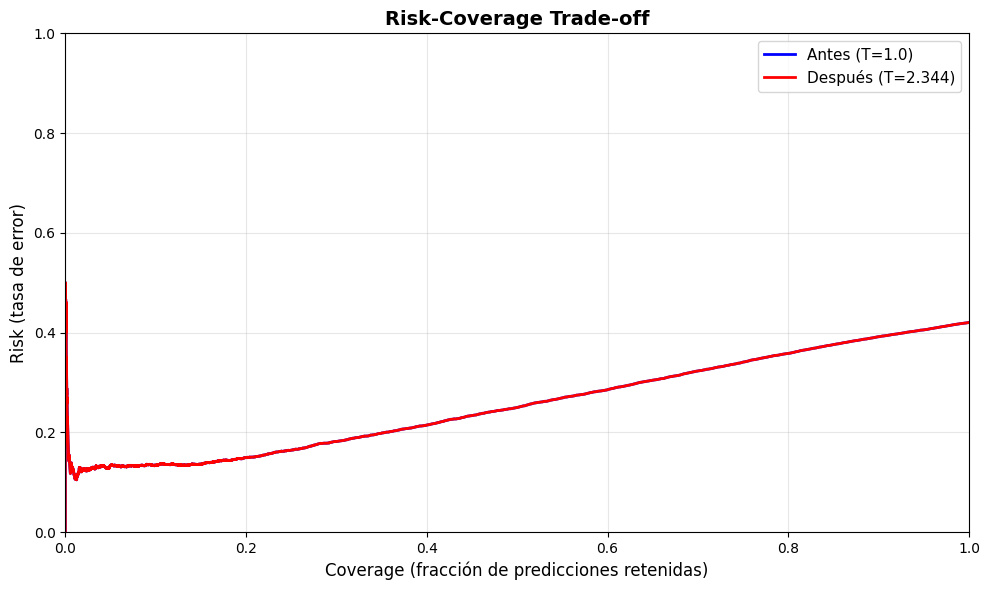

Guardado en: outputs/temperature_scaling/risk_coverage.png

AUC Risk-Coverage antes:  0.2569
AUC Risk-Coverage después: 0.2569
Mejora (menor es mejor): 0.0000


In [19]:
def compute_risk_coverage(scores, labels):
    """Calcula risk-coverage curve ordenando por confianza descendente"""
    order = np.argsort(scores)[::-1]
    scores_sorted = scores[order]
    labels_sorted = labels[order]
    
    coverages = []
    risks = []
    
    for i in range(1, len(scores_sorted) + 1):
        coverage = i / len(scores_sorted)
        risk = 1 - np.mean(labels_sorted[:i])
        coverages.append(coverage)
        risks.append(risk)
    
    return coverages, risks

eval_df = pd.read_csv(OUTPUT_DIR / 'eval_detections.csv')

# Antes de calibrar
scores_before = sigmoid(eval_df['logit'].values)
labels = eval_df['is_tp'].values
cov_before, risk_before = compute_risk_coverage(scores_before, labels)

# Después de calibrar
scores_after = sigmoid(eval_df['logit'].values / T_optimal)
cov_after, risk_after = compute_risk_coverage(scores_after, labels)

# Plotear
plt.figure(figsize=(10, 6))
plt.plot(cov_before, risk_before, 'b-', label='Antes (T=1.0)', linewidth=2)
plt.plot(cov_after, risk_after, 'r-', label=f'Después (T={T_optimal:.3f})', linewidth=2)
plt.xlabel('Coverage (fracción de predicciones retenidas)', fontsize=12)
plt.ylabel('Risk (tasa de error)', fontsize=12)
plt.title('Risk-Coverage Trade-off', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'risk_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Guardado en: {OUTPUT_DIR / 'risk_coverage.png'}")

# Calcular AUC
auc_before = np.trapz(risk_before, cov_before)
auc_after = np.trapz(risk_after, cov_after)
print(f"\nAUC Risk-Coverage antes:  {auc_before:.4f}")
print(f"AUC Risk-Coverage después: {auc_after:.4f}")
print(f"Mejora (menor es mejor): {auc_before - auc_after:.4f}")

## 12. Reporte Final y Resumen

In [20]:
with open(OUTPUT_DIR / 'calibration_metrics.json', 'r') as f:
    metrics = json.load(f)

report = f"""
{'='*70}
FASE 4: TEMPERATURE SCALING - REPORTE FINAL
{'='*70}

1. TEMPERATURA ÓPTIMA
   - T global: {T_optimal:.4f}

2. MÉTRICAS DE CALIBRACIÓN EN VAL_EVAL
   
   Métrica         | Antes (T=1.0)  | Después        | Mejora
   ----------------|----------------|----------------|---------------
   NLL             | {metrics_before['nll']:14.4f} | {metrics_after['nll']:14.4f} | {metrics_before['nll']-metrics_after['nll']:14.4f}
   Brier Score     | {metrics_before['brier']:14.4f} | {metrics_after['brier']:14.4f} | {metrics_before['brier']-metrics_after['brier']:14.4f}
   ECE             | {metrics_before['ece']:14.4f} | {metrics_after['ece']:14.4f} | {metrics_before['ece']-metrics_after['ece']:14.4f}

3. INTERPRETACIÓN
   - T > 1: Modelo sobreconfidente → Temperature Scaling reduce confianza
   - T < 1: Modelo subconfidente → Temperature Scaling aumenta confianza
   - T ≈ 1: Modelo ya bien calibrado
   
   En este caso: T = {T_optimal:.4f}
   {'→ El modelo era SOBRECONFIDENTE' if T_optimal > 1 else '→ El modelo era SUBCONFIDENTE' if T_optimal < 1 else '→ El modelo ya estaba calibrado'}

4. IMPACTO EN DETECCIÓN
   - mAP antes:  {map_before:.4f}
   - mAP después: {map_after:.4f}
   - Diferencia: {map_after - map_before:+.4f}
   
   → La calibración {'MEJORA' if map_after >= map_before else 'REDUCE LIGERAMENTE'} el rendimiento de detección

5. ARTEFACTOS GENERADOS
   ✓ {OUTPUT_DIR / 'temperature.json'}
   ✓ {OUTPUT_DIR / 'calib_detections.csv'}
   ✓ {OUTPUT_DIR / 'eval_detections.csv'}
   ✓ {OUTPUT_DIR / 'calibration_metrics.json'}
   ✓ {OUTPUT_DIR / 'reliability_diagram.png'}
   ✓ {OUTPUT_DIR / 'confidence_distribution.png'}
   ✓ {OUTPUT_DIR / 'risk_coverage.png'}
   {'✓ ' + str(OUTPUT_DIR / 'temperature_per_class.json') if (OUTPUT_DIR / 'temperature_per_class.json').exists() else ''}

6. CONCLUSIONES PARA ADAS
   - Las probabilidades calibradas son más coherentes con la realidad
   - Cuando el modelo dice p=0.8, ahora acierta ~80% de las veces
   - Esto permite tomar decisiones de confianza más informadas
   - Crucial para aplicaciones de seguridad donde la confianza importa

{'='*70}
FASE 4 COMPLETADA EXITOSAMENTE
{'='*70}
"""

print(report)

with open(OUTPUT_DIR / 'final_report.txt', 'w') as f:
    f.write(report)

print(f"\nReporte guardado en: {OUTPUT_DIR / 'final_report.txt'}")


FASE 4: TEMPERATURE SCALING - REPORTE FINAL

1. TEMPERATURA ÓPTIMA
   - T global: 2.3439

2. MÉTRICAS DE CALIBRACIÓN EN VAL_EVAL
   
   Métrica         | Antes (T=1.0)  | Después        | Mejora
   ----------------|----------------|----------------|---------------
   NLL             |         0.6996 |         0.6824 |         0.0172
   Brier Score     |         0.2527 |         0.2447 |         0.0080
   ECE             |         0.1934 |         0.1516 |         0.0419

3. INTERPRETACIÓN
   - T > 1: Modelo sobreconfidente → Temperature Scaling reduce confianza
   - T < 1: Modelo subconfidente → Temperature Scaling aumenta confianza
   - T ≈ 1: Modelo ya bien calibrado
   
   En este caso: T = 2.3439
   → El modelo era SOBRECONFIDENTE

4. IMPACTO EN DETECCIÓN
   - mAP antes:  0.1819
   - mAP después: 0.1819
   - Diferencia: +0.0000
   
   → La calibración MEJORA el rendimiento de detección

5. ARTEFACTOS GENERADOS
   ✓ outputs/temperature_scaling/temperature.json
   ✓ outputs/temperat

## 13. Análisis de Calibración por Clase

MÉTRICAS DE CALIBRACIÓN POR CLASE

     category  n_samples  nll_before  nll_after  ece_before  ece_after  brier_before  brier_after  nll_improvement  ece_improvement
       person       3456    0.596869   0.638016    0.104390   0.128816      0.203992     0.222730        -0.041146        -0.024427
        rider         66    0.346631   0.518974    0.266169   0.385673      0.087353     0.164080        -0.172344        -0.119504
          car      11251    0.857634   0.750612    0.452952   0.389598      0.327485     0.278441         0.107022         0.063355
        truck       1881    0.542962   0.616115    0.137189   0.215016      0.178317     0.211872        -0.073154        -0.077827
          bus        821    0.433061   0.561378    0.214839   0.309944      0.127296     0.184947        -0.128317        -0.095105
        train        149    0.390744   0.544212    0.312238   0.411931      0.106764     0.176381        -0.153468        -0.099693
   motorcycle       1026    0.436631   0.

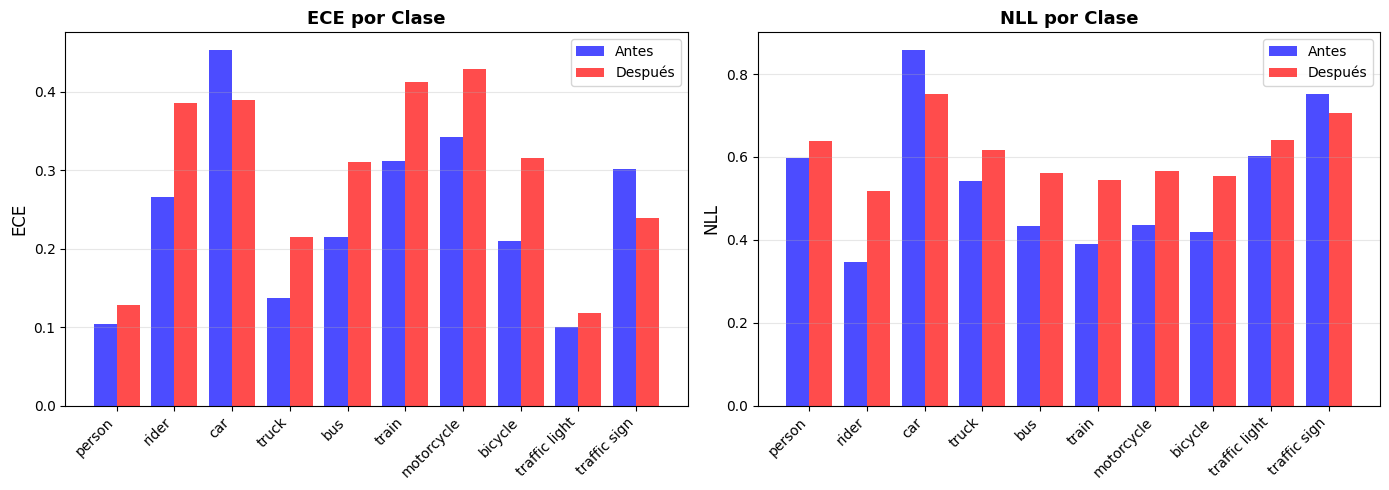

Gráfica guardada en: outputs/temperature_scaling/calibration_per_class.png


In [21]:
eval_df = pd.read_csv(OUTPUT_DIR / 'eval_detections.csv')

per_class_metrics = []

for cat in CONFIG['categories']:
    cat_data = eval_df[eval_df['category'] == cat]
    
    if len(cat_data) < 10:
        continue
    
    logits_cat = cat_data['logit'].values
    labels_cat = cat_data['is_tp'].values
    
    # Antes
    metrics_cat_before = compute_calibration_metrics(logits_cat, labels_cat, T=1.0)
    
    # Después (T global)
    metrics_cat_after = compute_calibration_metrics(logits_cat, labels_cat, T=T_optimal)
    
    per_class_metrics.append({
        'category': cat,
        'n_samples': len(cat_data),
        'nll_before': metrics_cat_before['nll'],
        'nll_after': metrics_cat_after['nll'],
        'ece_before': metrics_cat_before['ece'],
        'ece_after': metrics_cat_after['ece'],
        'brier_before': metrics_cat_before['brier'],
        'brier_after': metrics_cat_after['brier']
    })

df_per_class = pd.DataFrame(per_class_metrics)
df_per_class['nll_improvement'] = df_per_class['nll_before'] - df_per_class['nll_after']
df_per_class['ece_improvement'] = df_per_class['ece_before'] - df_per_class['ece_after']

df_per_class.to_csv(OUTPUT_DIR / 'calibration_per_class.csv', index=False)

print("MÉTRICAS DE CALIBRACIÓN POR CLASE\n")
print(df_per_class.to_string(index=False))
print(f"\nGuardado en: {OUTPUT_DIR / 'calibration_per_class.csv'}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cats = df_per_class['category'].values
x_pos = np.arange(len(cats))

# ECE
axes[0].bar(x_pos - 0.2, df_per_class['ece_before'], 0.4, label='Antes', alpha=0.7, color='blue')
axes[0].bar(x_pos + 0.2, df_per_class['ece_after'], 0.4, label='Después', alpha=0.7, color='red')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(cats, rotation=45, ha='right')
axes[0].set_ylabel('ECE', fontsize=12)
axes[0].set_title('ECE por Clase', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# NLL
axes[1].bar(x_pos - 0.2, df_per_class['nll_before'], 0.4, label='Antes', alpha=0.7, color='blue')
axes[1].bar(x_pos + 0.2, df_per_class['nll_after'], 0.4, label='Después', alpha=0.7, color='red')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cats, rotation=45, ha='right')
axes[1].set_ylabel('NLL', fontsize=12)
axes[1].set_title('NLL por Clase', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'calibration_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Gráfica guardada en: {OUTPUT_DIR / 'calibration_per_class.png'}")

## 14. Checklist de Verificación

In [22]:
print("="*70)
print("CHECKLIST DE VERIFICACIÓN - ¿FUNCIONÓ LA CALIBRACIÓN?")
print("="*70)

with open(OUTPUT_DIR / 'calibration_metrics.json', 'r') as f:
    metrics = json.load(f)

T_opt = metrics['T_optimal']
nll_before = metrics['val_eval']['before']['nll']
nll_after = metrics['val_eval']['after']['nll']
ece_before = metrics['val_eval']['before']['ece']
ece_after = metrics['val_eval']['after']['ece']
brier_before = metrics['val_eval']['before']['brier']
brier_after = metrics['val_eval']['after']['brier']

checks = []

# Check 1: T es significativamente diferente de 1
if abs(T_opt - 1.0) > 0.1:
    checks.append(("✓", f"T={T_opt:.3f} es diferente de 1.0 → Había desbalance"))
else:
    checks.append(("⚠️", f"T={T_opt:.3f} muy cerca de 1.0 → Modelo ya estaba calibrado"))

# Check 2: NLL mejoró
if nll_after < nll_before:
    improvement = ((nll_before - nll_after) / nll_before) * 100
    checks.append(("✓", f"NLL mejoró {improvement:.1f}% ({nll_before:.4f} → {nll_after:.4f})"))
else:
    checks.append(("❌", f"NLL NO mejoró ({nll_before:.4f} → {nll_after:.4f})"))

# Check 3: ECE mejoró
if ece_after < ece_before:
    improvement = ((ece_before - ece_after) / ece_before) * 100
    checks.append(("✓", f"ECE mejoró {improvement:.1f}% ({ece_before:.4f} → {ece_after:.4f})"))
else:
    checks.append(("❌", f"ECE NO mejoró ({ece_before:.4f} → {ece_after:.4f})"))

# Check 4: Brier mejoró
if brier_after < brier_before:
    improvement = ((brier_before - brier_after) / brier_before) * 100
    checks.append(("✓", f"Brier mejoró {improvement:.1f}% ({brier_before:.4f} → {brier_after:.4f})"))
else:
    checks.append(("❌", f"Brier NO mejoró ({brier_before:.4f} → {brier_after:.4f})"))

# Check 5: mAP se mantuvo (debe ser casi igual)
if 'map_before' in dir() and 'map_after' in dir():
    map_diff = abs(map_after - map_before)
    if map_diff < 0.01:
        checks.append(("✓", f"mAP se mantuvo ({map_before:.4f} → {map_after:.4f})"))
    else:
        checks.append(("⚠️", f"mAP cambió significativamente ({map_before:.4f} → {map_after:.4f})"))

print("\nRESULTADOS:")
print("-"*70)
for status, msg in checks:
    print(f"{status} {msg}")

print("\n" + "="*70)

# Diagnóstico si no funcionó
passed = sum(1 for s, _ in checks if s == "✓")
total = len(checks)

if passed >= 3:
    print("✅ CALIBRACIÓN EXITOSA")
    print("\nLa temperatura ajustó correctamente las probabilidades.")
    print("Las métricas de calibración mejoraron como se esperaba.")
elif T_opt < 1.05 and T_opt > 0.95:
    print("⚠️  MODELO YA ESTABA BIEN CALIBRADO")
    print("\nT ≈ 1.0 indica que el modelo baseline ya tenía buena calibración.")
    print("Esto es POSITIVO: no necesitas aplicar temperatura en producción.")
else:
    print("❌ PROBLEMA DETECTADO")
    print("\nPosibles causas:")
    print("1. Conversión incorrecta score→logit (revisar función sigmoid inversa)")
    print("2. Dataset muy pequeño para optimizar T")
    print("3. Distribución muy diferente entre val_calib y val_eval")
    print("\nRevisa:")
    print("- El diagnóstico en val_calib (Celda anterior)")
    print("- Los reliability diagrams (deben mostrar mejora visual)")
    print("- La distribución de scores (histogramas)")

print("="*70)

CHECKLIST DE VERIFICACIÓN - ¿FUNCIONÓ LA CALIBRACIÓN?

RESULTADOS:
----------------------------------------------------------------------
✓ T=2.344 es diferente de 1.0 → Había desbalance
✓ NLL mejoró 2.5% (0.6996 → 0.6824)
✓ ECE mejoró 21.6% (0.1934 → 0.1516)
✓ Brier mejoró 3.2% (0.2527 → 0.2447)
✓ mAP se mantuvo (0.1819 → 0.1819)

✅ CALIBRACIÓN EXITOSA

La temperatura ajustó correctamente las probabilidades.
Las métricas de calibración mejoraron como se esperaba.
